#  DSC478 - Programming Machine Learning Applications
## Assignment 3 - Lavinia Wang

### Problem 2. Automatic Document Clustering 

Use a different subset of the 20 Newsgroup data set which includes 2,500 documents (newsgroup posts), each belonging to one of 5 categories windows (0), crypt (1), christian (2), hockey (3), forsale (4). The documents are represented by 9328 terms (stems). The dictionary (vocabulary) for the data set is given in the file "terms.txt" and the full term-by-document matrix is given in "matrix.txt" (comma separated values). The actual category labels for the documents are provided in the file "classes.txt".Goal in this assignment is to perform clustering on the documents and compare the clusters to the actual categories.

Dataset: <a href='http://facweb.cs.depaul.edu/mobasher/classes/CSC478/Data/newsgroups5.zip'>newgroup.txt</a> Dataset description <a href='http://qwone.com/~jason/20Newsgroups/'>here</a>

In [1]:
# Import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os 

from sklearn.model_selection import train_test_split
from sklearn.metrics import completeness_score, homogeneity_score

In [2]:
# Change working directory
os.chdir('/resources/CSC478/Assignment3')

#### a. Create your own distance function that, instead of using Euclidean distance, uses Cosine similarity. This is the distance function you will use to pass to the kMeans function.

In [3]:
def cosSim(vecA, vecB):
    #D_norm = array([linalg.norm(data[i]) for i in range(len(data))])
    #x_norm = linalg.norm(inX)
    #cosines = dot(data,inX)/(D_norm * x_norm)
    #distances = 1 - cosines
    
    norm_A = linalg.norm(vecA)
    norm_B = linalg.norm(vecB)
    cosine = dot(vecA, vecB) / (norm_A * norm_B)
    distance = 1 - cosine
    return distance

#### b. Load the data set [Note: the data matrix provided has terms as rows and documents as columns. Since you will be clustering documents, you'll need to take the transpose of this matrix so that your main data matrix is a document x term matrix. In Numpy, you may use the ".T" operation to obtain the transpose.] Then, split the data set (the document x term matrix) and set aside 20% for later use (see below). Use the 80% segment for clustering in the next part. The 20% portion must be a random subset.

In [4]:
# Load data from files
matrix = np.genfromtxt("matrix.txt", delimiter=',',dtype=int).T
matrix.shape

(2500, 9328)

In [5]:
classes = np.genfromtxt("classes.txt", delimiter=' ', dtype=int, skip_header=1, usecols=(1))
classes.shape

(2500,)

In [6]:
classes

array([0, 1, 1, ..., 3, 4, 2])

In [7]:
terms = pd.read_table('terms.txt', sep='\n', header=None)
terms.shape

(9328, 1)

In [8]:
terms.head(10)

,0
0,aa
1,aargh
2,aaron
3,aaronc
4,ab
5,abandon
6,abc
7,abid
8,abil
9,abl


In [9]:
# Split the data set 80%-20%
train, test, classes_train, classes_test = train_test_split(matrix, classes, test_size=0.2, random_state=33)
print(train.shape, test.shape, classes_train.shape, classes_test.shape)

(2000, 9328) (500, 9328) (2000,) (500,)


#### c. Perform Kmeans clustering on the training data. Write a function to display the top N terms in each cluster along with the cluster DF values for each term and the size of the cluster. The cluster DF value for a term t in a cluster C is the percentage of docs in cluster C in which term t appears (so, if a cluster has 500 documents, and term "game" appears in 100 of those 500 documents, then DF value of "game" in that cluster is 0.2 or 20%). Sort the terms for each cluster in decreasing order of the DF percentage. Here is an example of how this output might look like (here the top 10 terms for 3 of the 5 clusters are displayed in decreasing order of cluster DF values, but the mean frequnecy from the cluster centroid is also shown). [Extra Credit: use your favorite third party tool, ideally with a Python based API, to create a word cloud for each cluster.]

In [10]:
# Implementation from Chapter-10
from numpy import *

def distEclud(vecA, vecB):
    return sqrt(sum(power(vecA - vecB, 2))) #la.norm(vecA-vecB)

def randCent(dataSet, k):
    n = shape(dataSet)[1]
    centroids = zeros((k,n), dtype=float)
    for j in range(n):
        minJ = min(dataSet[:,j])
        rangeJ = float(max(dataSet[:,j]) - minJ)
        centroids[:,j] = minJ + rangeJ * random.rand(k) 
    return centroids 

def kMeans(dataSet, k, distMeas=cosSim, createCent=randCent):
    m = shape(dataSet)[0]
    clusterAssment = zeros((m,2)) #create mat to assign data points to a centroid, also holds SE of each point
    centroids = createCent(dataSet, k)
    clusterChanged = True
    while clusterChanged:
        clusterChanged = False
        for i in range(m):#for each data point assign it to the closest centroid
            minDist = inf; minIndex = -1
            for j in range(k):
                distJI = distMeas(centroids[j,:],dataSet[i,:])
                if distJI < minDist:
                    minDist = distJI; minIndex = j
            if clusterAssment[i,0] != minIndex: clusterChanged = True
            clusterAssment[i,:] = minIndex,minDist**2
        # print centroids
        for cent in range(k):#recalculate centroids
            ptsInClust = dataSet[nonzero(clusterAssment[:,0]==cent)[0]] #get all the point in this cluster - Note: this was incorrect in the original distribution.
            if(len(ptsInClust)!=0):
                centroids[cent,:] = mean(ptsInClust, axis=0) #assign centroid to mean - Note condition was added 10/28/2013
    return centroids, clusterAssment

def biKmeans(dataSet, k, distMeas=distEclud):
    m = shape(dataSet)[0]
    clusterAssment = mat(zeros((m,2)))
    centroid0 = mean(dataSet, axis=0).tolist()[0]
    centList =[centroid0] #create a list with one centroid
    for j in range(m): #calc initial Error
        clusterAssment[j,1] = distMeas(mat(centroid0), dataSet[j,:])**2
    while (len(centList) < k):
        lowestSSE = inf
        for i in range(len(centList)):
            ptsInCurrCluster = dataSet[nonzero(clusterAssment[:,0].A==i)[0],:] #get the data points currently in cluster i
            centroidMat, splitClustAss = kMeans(ptsInCurrCluster, 2, distMeas)
            sseSplit = sum(splitClustAss[:,1])#compare the SSE to the currrent minimum
            sseNotSplit = sum(clusterAssment[nonzero(clusterAssment[:,0].A!=i)[0],1])
            print("sseSplit, and notSplit: ",sseSplit,sseNotSplit)
            if (sseSplit + sseNotSplit) < lowestSSE:
                bestCentToSplit = i
                bestNewCents = centroidMat
                bestClustAss = splitClustAss.copy()
                lowestSSE = sseSplit + sseNotSplit
        bestClustAss[nonzero(bestClustAss[:,0] == 1)[0],0] = len(centList) #change 1 to 3, 4, or whatever
        bestClustAss[nonzero(bestClustAss[:,0] == 0)[0],0] = bestCentToSplit
        print('the bestCentToSplit is: ',bestCentToSplit)
        print('the len of bestClustAss is: ', len(bestClustAss))
        centList[bestCentToSplit] = bestNewCents[0,:].tolist()[0]#replace a centroid with two best centroids 
        centList.append(bestNewCents[1,:].tolist()[0])
        clusterAssment[nonzero(clusterAssment[:,0].A == bestCentToSplit)[0],:]= bestClustAss#reassign new clusters, and SSE
    return mat(centList), clusterAssment

In [18]:
centroids, clusters = kMeans((train), 5, cosSim, randCent)

In [19]:
def top_terms(N, centroids, clusters):
    term_list = pd.Series(terms[0], name='Term')
    clusters = pd.DataFrame(clusters)
    for i in range(5):
        clust_index = np.array(clusters.index[clusters.iloc[:,0] == i])
        centroid = pd.Series(centroids[i], name='Centroid_value')
        clust = pd.concat([term_list, centroid], axis=1)
        clust_docs = len(clust_index)
        print('CLUSTER ' + str(i) + ' results:')
        print('Number of documents in cluster: ' + str(clust_docs))
        print("\tword\tDF\tPercentofDocs")
        clust_df = clust.iloc[clust_index]
        clust_df.sort_values(by='Centroid_value', axis=0, ascending=False, inplace=True)
        top_n = clust_df.head(N)
        for t in top_n.itertuples():
            doc_freq = t.Centroid_value * clust_docs
            PercentofDocs = t.Centroid_value *100
            print("%10s\t\t%.0f\t%.6f" %(t.Term, doc_freq, PercentofDocs))
    
top_terms(10, centroids, clusters)

CLUSTER 0 results:
Number of documents in cluster: 360
	word	DF	PercentofDocs
    christ		252	70.000000
    cathol		137	38.055556
    accept		131	36.388889
   baptism		75	20.833333
   against		68	18.888889
     chang		60	16.666667
    commun		59	16.388889
     appli		56	15.555556
      base		54	15.000000
     canon		48	13.333333
CLUSTER 1 results:
Number of documents in cluster: 850
	word	DF	PercentofDocs
     david		180	21.176471
    appear		148	17.411765
      code		141	16.588235
       cup		139	16.352941
    better		136	16.000000
       dai		122	14.352941
        bh		120	14.117647
       ask		110	12.941176
     cours		107	12.588235
   clinton		104	12.235294
CLUSTER 2 results:
Number of documents in cluster: 6
	word	DF	PercentofDocs
    ashton		0	0.000000
   atlanta		0	0.000000
        bo		0	0.000000
    broken		0	0.000000
cypherpunk		0	0.000000
 dcsedacuk		0	0.000000
CLUSTER 3 results:
Number of documents in cluster: 777
	word	DF	PercentofDocs
    articl		170	21.879022
    comput		1

/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


Use "pip install wordcloud" first to install wordcloud for extra credit.

In [20]:
c0 = pd.DataFrame(train[clusters[:,0]==0])
c1 = pd.DataFrame(train[clusters[:,0]==1])
c2 = pd.DataFrame(train[clusters[:,0]==2])
c3 = pd.DataFrame(train[clusters[:,0]==3])
c4 = pd.DataFrame(train[clusters[:,0]==4])

terms_array = np.array(terms)
c0.columns = terms_array.T[0]
c1.columns = terms_array.T[0]
c2.columns = terms_array.T[0]
c3.columns = terms_array.T[0]
c4.columns = terms_array.T[0]

c0_doc_freq = list(np.array((c0.T!=0).sum(1).T))
c1_doc_freq = list(np.array((c1.T!=0).sum(1).T))
c2_doc_freq = list(np.array((c2.T!=0).sum(1).T))
c3_doc_freq = list(np.array((c3.T!=0).sum(1).T))
c4_doc_freq = list(np.array((c4.T!=0).sum(1).T))

t_list = list(terms_array.T[0])

c0_terms = ""
c1_terms = ""
c2_terms = ""
c3_terms = ""
c4_terms = ""

pos = 0
for i in c0_doc_freq:
    for j in range(i):
        c0_terms += t_list[pos] + " "
    pos += 1

pos = 0
for i in c1_doc_freq:
    for j in range(i):
        c1_terms += t_list[pos] + " "
    pos += 1

pos = 0
for i in c2_doc_freq:
    for j in range(i):
        c2_terms += t_list[pos] + " "
    pos += 1
    
pos = 0
for i in c3_doc_freq:
    for j in range(i):
        c3_terms += t_list[pos] + " "
    pos += 1
    
pos = 0
for i in c4_doc_freq:
    for j in range(i):
        c4_terms += t_list[pos] + " "
    pos += 1

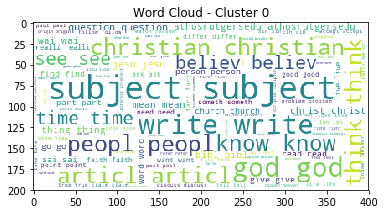

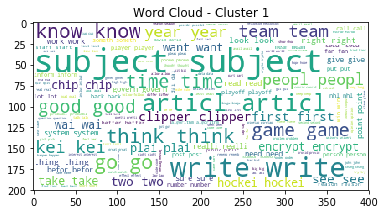

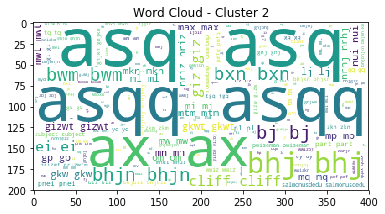

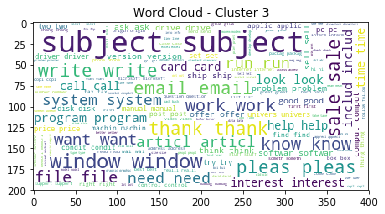

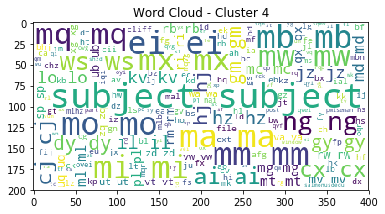

In [21]:
from wordcloud import WordCloud

c0_wordcloud = WordCloud(background_color='white').generate(c0_terms)
plt.imshow(c0_wordcloud)
plt.title('Word Cloud - Cluster 0')
plt.show()

c1_wordcloud = WordCloud(background_color='white').generate(c1_terms)
plt.imshow(c1_wordcloud)
plt.title('Word Cloud - Cluster 1')
plt.show()

c2_wordcloud = WordCloud(background_color='white').generate(c2_terms)
plt.imshow(c2_wordcloud)
plt.title('Word Cloud - Cluster 2')
plt.show()

c3_wordcloud = WordCloud(background_color='white').generate(c3_terms)
plt.imshow(c3_wordcloud)
plt.title('Word Cloud - Cluster 3')
plt.show()

c4_wordcloud = WordCloud(background_color='white').generate(c4_terms)
plt.imshow(c4_wordcloud)
plt.title('Word Cloud - Cluster 4')
plt.show()

#### d. Using the cluster assignments from Kmeans clustering, compare your 5 clusters to the 5 pre-assigned classes by computing the Completeness and Homogeneity values.

In [22]:
completeness = completeness_score(classes_train, ravel(clusters.T[0]))
homogeneity = homogeneity_score(classes_train,ravel(clusters.T[0]))

print('Completeness of Cluster: '+  str(completeness))
print('Homogeneity of Clusters: '+ str(homogeneity))

Completeness of Cluster: 0.7039396795876112
Homogeneity of Clusters: 0.47105244197448215


#### e. Finally, using your cluster assignments as class labels, categorize each of the documents in the 20% set-aside data into each of the appropriate cluster. Your categorization should be based on Cosine similarity between each test document and cluster centroids. For each test document show the predicted class label as well as Cosine similarity to the corresponding cluster.

In [23]:
results = []

for doc in test:
    dic = {}
    sim = []
    cluster = 0
    for centroid in centroids:
        cluster += 1
        centroid_doc_sim = 1 - cosSim(doc, centroid) #Need to subtract from 1 as our function returns distance and not similarity
        sim.append(centroid_doc_sim) 
        dic['Cosine Similarity to Cluster '+str(cluster)] = centroid_doc_sim
    dic['Predicted Cluster'] = sim.index(max(sim))+1
    results.append(dic)

test_cluster = pd.DataFrame(results)

In [24]:
test_cluster.head(20)

,Cosine Similarity to Cluster 1,Cosine Similarity to Cluster 2,Cosine Similarity to Cluster 3,Cosine Similarity to Cluster 4,Cosine Similarity to Cluster 5,Predicted Cluster
0,0.209108,0.152343,0.000023,0.133454,0.005869,1
1,0.194800,0.160859,0.000007,0.127390,0.006105,1
2,0.112840,0.133198,0.000031,0.156791,0.037270,4
3,0.217297,0.273139,0.000027,0.400973,0.015119,4
4,0.066069,0.130035,0.000018,0.158256,0.009109,4
5,0.195819,0.431167,0.000022,0.204174,0.006461,2
6,0.218651,0.390383,0.000011,0.197197,0.006860,2
7,0.137683,0.171038,0.000022,0.169526,0.005589,2
8,0.550619,0.222930,0.000006,0.168217,0.006649,1
9,0.173495,0.115939,0.000010,0.105743,0.004774,1


In [25]:
centroids

array([[0.00277778, 0.        , 0.18055556, ..., 0.        , 0.        ,
        0.        ],
       [0.00117647, 0.00470588, 0.00117647, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.16666667, 0.        ,
        0.        ],
       [0.003861  , 0.        , 0.00900901, ..., 0.        , 0.        ,
        0.        ],
       [0.28571429, 0.        , 0.        , ..., 0.28571429, 0.14285714,
        0.85714286]])